## Parameters

A parameter is anything that a model uses to constrain its predictions. Commonly, a parameter is a quantity that helps to describe a data set or a distribution. For example, the mean of a normal distribution is a parameter; in fact, we say that a normal distribution is parametrized by its mean and variance. If we take the mean of a set of samples drawn from the normal distribution, we get an estimate of the mean of the distribution. Similarly, the mean of a set of observations is an estimate of the parameter of the underlying distribution (which is often assumed to be normal). Other parameters include the median, the correlation coefficient to another series, the standard deviation, and every other measurement of a data set.

## You Never Know, You Only Estimate

When you take the mean of a data set, you do not know the mean. You have estimated the mean as best you can from the data you have. The estimate can be off. This is true of any parameter you estimate. To actually understand what is going on you need to determine how good your estimate is by looking at its stability/standard error/confidence intervals.

## Instability of estimates

Whenever we consider a set of observations, our calculation of a parameter can only be an estimate. It will change as we take more measurements or as time passes and we get new observations. We can quantify the uncertainty in our estimate by looking at how the parameter changes as we look at different subsets of the data. For instance, standard deviation describes how different the mean of a set is from the mean of each observation, that is, from each observation itself. In financial applications, data often comes in time series. In this case, we can estimate a parameter at different points in time; say, for the previous 30 days. By looking at how much this moving estimate fluctuates as we change our time window, we can compute the instability of the estimated parameter.

In [1]:
# We'll be doing some examples, so let's import the libraries we'll need
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Example: mean and standard deviation

First, let's take a look at some samples from a normal distribution. We know that the mean of the distribution is 0 and the standard deviation is 1; but if we measure the parameters from our observations, we will get only approximately 0 and approximately 1. We can see how these estimates change as we take more and more samples:

Mean for observations #1 - #9: -0.26951611032632805
Mean for observations #1 - #99: 0.027109073490359778
Mean for observations #1 - #249: -0.020616059111720507
Mean for all the observations: -0.038643973513210604


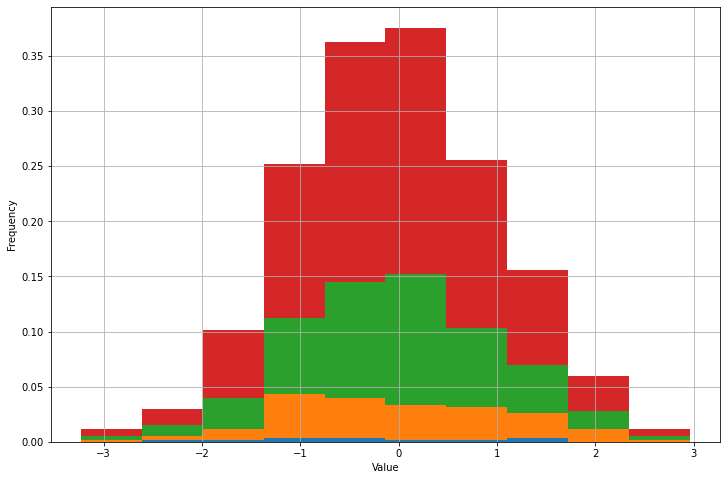

In [13]:
# Set a seed so we can play with the data without generating new random numbers every time
np.random.seed(123)

# Let us calculate the means:
normal = np.random.randn(500)
print(f"Mean for observations #1 - #9: {np.mean(normal[:10])}")
print(f"Mean for observations #1 - #99: {np.mean(normal[:100])}")
print(f"Mean for observations #1 - #249: {np.mean(normal[:250])}")
print(f"Mean for all the observations: {np.mean(normal)}")

# We set the defailt size of the figure:
plt.rcParams["figure.figsize"] = (12,8)

# We plot a histogram of the data:
plt.hist([normal[:10], normal[:100], normal[:250], normal], density=1, histtype='bar', stacked=True)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid();

In [15]:
print(f"Standard Deviation for observations #1 - #9: {np.std(normal[:10])}")
print(f"Standard Deviation for observations #1 - #99: {np.std(normal[:100])}")
print(f"Standard Deviation for observations #1 - #249: {np.std(normal[:250])}")
print(f"Standard Deviation for all the observations: {np.std(normal)}")


Standard Deviation for observations #1 - #9: 1.236304801499023
Standard Deviation for observations #1 - #99: 1.128240470477961
Standard Deviation for observations #1 - #249: 1.0174604368340197
Standard Deviation for all the observations: 1.0032028561568238


## Example: When the underlying distribution is not normal

In [28]:
# Generate some data for bi-model distribution:
def bimodal(n):
    X = np.zeros((n))
    for i in range(n):
        if np.random.binomial(1, 0.5) == 0:
            X[i] = np.random.normal(-5, 1)
        else:
            X[i] =  np.random.normal(5, 1)
    return X

Mean: 0.16332198702429035
Standard Deviation: 5.089104291502497


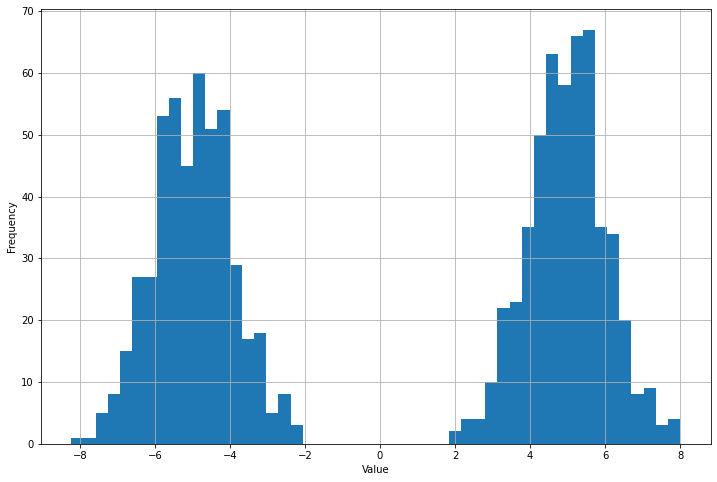

In [47]:
# Let us plot this data:
X = bimodal(1000)
plt.hist(X, bins = 50)
plt.ylabel('Frequency')
plt.xlabel('Value')
print(f"Mean: {np.mean(X)}")
print(f"Standard Deviation: {np.std(X)}")
plt.grid();

Sure enough, the mean is incredibly non-informative about what is going on in the data. We have collapsed all of our data into a single estimate, and lost of a lot of information doing so. This is what the distribution should look like if our hypothesis that it is normally distributed is correct.

We will be modelling our data based on the above mean and standard deviation and assuming that we have a normal distribution when in real none of the data would be coming from that region! This would be a blunder. Let us have a look!

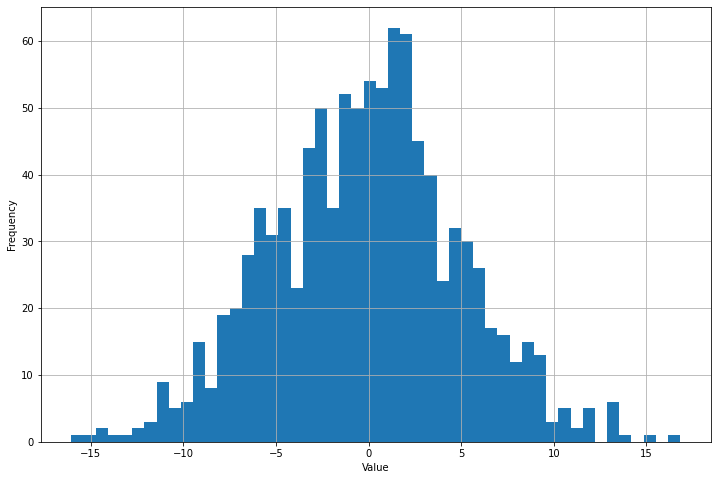

In [32]:
mu = np.mean(X)
sigma = np.std(X)

N = np.random.normal(mu, sigma, 1000)

plt.hist(N, bins=50)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid();

In [48]:
# Now, let us do Jarque-Bera test to check if our data was normal or not:
from statsmodels.stats.stattools import jarque_bera
p_value = jarque_bera(X)[2]

In [49]:
def outcome(p, level):
    if p<=level:
        print("We reject the Null hypothesis. The data does not seem to come from a normal distribution")
    else:
        print("We accept the Null Hypothesis. The data seems to come from normal distribution.")

In [50]:
outcome(p_value, 0.05)

We reject the Null hypothesis. The data does not seem to come from a normal distribution


## Example: Sharpe Ratio

One statistic often used to describe the performance of assets and portfolios is the Sharpe ratio, which measures the additional return per unit additional risk achieved by a portfolio, relative to a risk-free source of return such as Treasury bills: $$R = \frac{E[r_a - r_b]}{\sqrt{Var(r_a - r_b)}}$$

where $r_a$ is the returns on our asset and $r_b$ is the risk-free rate of return. As with mean and standard deviation, we can compute a rolling Sharpe ratio to see how our estimate changes through time.

In [54]:
# First we define the function for sharpe ratio:
def sharpe_ratio(asset, riskfree):
    return (np.mean(asset-riskfree))/(np.std(asset-riskfree))

In [58]:
# Now, we pick up our asset, say "AMZN" and we take "T-Bills" as our parameter for risk-free returns:
import pandas_datareader.data as web
import datetime as dt

start = dt.datetime(2012,1,1)
end = dt.datetime(2015,1,1)

benchmark = web.DataReader('BIL', "yahoo", start, end)['Adj Close']
asset = web.DataReader('AMZN', "yahoo", start, end)['Adj Close']

# Now we have the closings, we can calculate returns and the riskfree_returns:
riskfree = benchmark.pct_change()[1:]
returns = asset.pct_change()[1:]

# Now we calculate te running sharpe ratio:
running_sharpe = [sharpe_ratio(returns[i-90: i], riskfree[i-90: i]) for i in range(90, len(returns))]

<ipython-input-105-49d381c8833d>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([asset.index[int(i)].date() for i in ticks[:-1]])


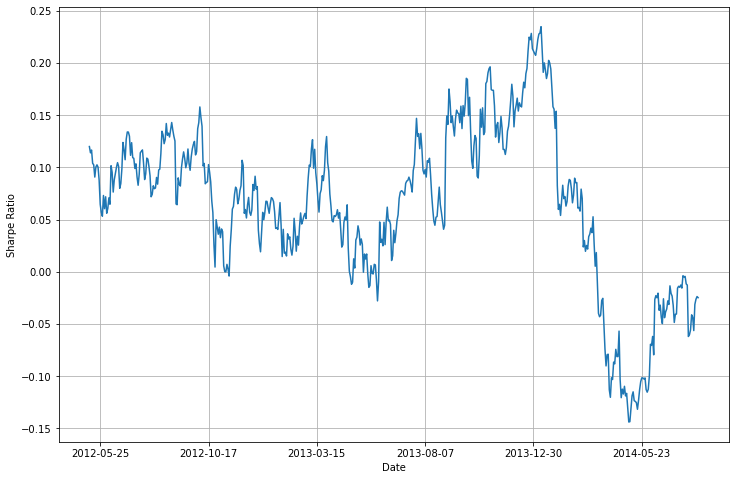

In [105]:
# Now we plot running Sharpe Ration upto 100 days before the end of the data set:
_, ax1 = plt.subplots()
ax1.plot(range(90, len(returns)-100), running_sharpe[:-100]);
ticks = ax1.get_xticks()
ax1.set_xticklabels([asset.index[int(i)].date() for i in ticks[:-1]])
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.grid();

The Sharpe ratio looks rather volatile, and it's clear that just reporting it as a single value will not be very helpful for predicting future values. Instead, we can compute the mean and standard deviation of the data above, and then see if it helps us predict the Sharpe ratio for the next 100 days.

<ipython-input-109-71d0717023d9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels([asset.index[int(i)].date() for i in ticks[:-1]]) # Label x-axis with dates


Mean of running Sharpe ratio: 0.06406515636134501
std of running Sharpe ratio: 0.07774919255045305


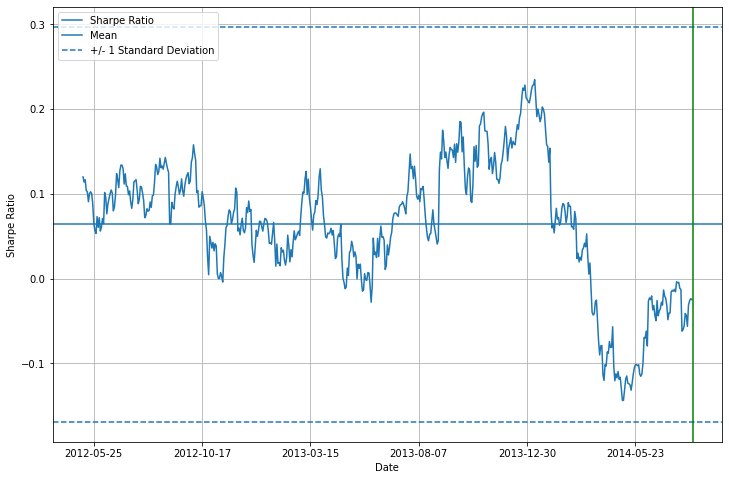

In [109]:
# Compute the mean and std of the running Sharpe ratios up to 100 days before the end
mean_rs = np.mean(running_sharpe[:-100])
std_rs = np.std(running_sharpe[:-100])

# Plotting running Sharpe Ratio:
_, ax2 = plt.subplots()
ax2.set_xticklabels([asset.index[int(i)].date() for i in ticks[:-1]]) # Label x-axis with dates
ax2.plot(range(90, len(returns)-100), running_sharpe[:-100]);
plt.grid();

# Plotting the mean and the +/- standard deviation lines:
ax2.axhline(mean_rs)
ax2.axhline(mean_rs + std_rs, linestyle='--')
ax2.axhline(mean_rs - std_rs, linestyle='--')

# Indicate where we computed the mean and standard deviations
# Everything after this is 'out of sample' which we are comparing with the estimated mean and std
ax2.axvline(len(returns) - 100, color='green');
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.legend(['Sharpe Ratio', 'Mean', '+/- 1 Standard Deviation'])

print(f'Mean of running Sharpe ratio: {mean_rs}')
print(f'std of running Sharpe ratio: {std_rs}')


## Example: Moving Average 

Let's say you take the average with a lookback window; how would you determine the standard error on that estimate? Let's start with an example showing a 90-day moving average.

In [130]:
# We load the time-series of the pricing:
start = dt.datetime(2012,1,1)
end = dt.datetime(2015,1,1)
pricing = web.DataReader('AMZN', "yahoo", start, end)['Adj Close']

# We compute the rolling mean for each day:
mu = pricing.rolling(90).mean()

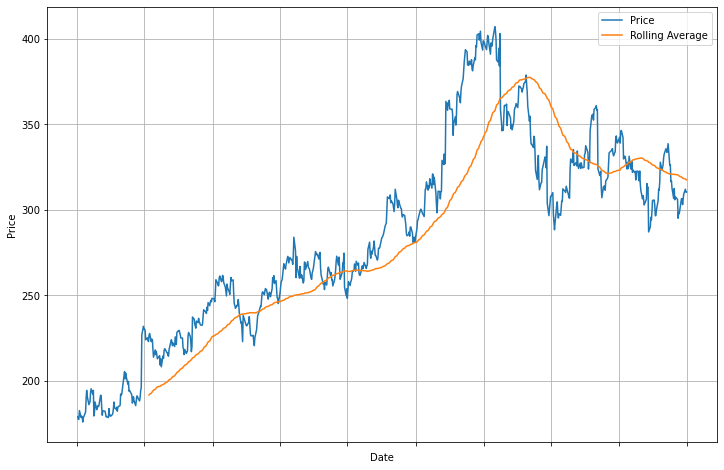

In [134]:
# Now we plot the pricing data:
fig, ax1 = plt.subplots()
ax1.plot(pricing)
ticks = ax1.get_xticks()
ax1.set_xticklabels([pricing.index[int(i)].date() for i in ticks[:-10]]) # Label x-axis with dates
plt.ylabel('Price')
plt.xlabel('Date')

# we plot the rolling mean:
ax1.plot(mu);
plt.legend(['Price','Rolling Average']);
plt.grid()
